This project is aimed at building a mobile app, that can accurately predict the class of food across Africa

- First step is to start with Nigeria, Yoruba indigenous food like Amala, pupuru, moimoi etc
- Second step is to gather the dsataset, either by getting it online or by webscraping
- Third step is to then preprocess the data and build the model

Steps will be updated as I progress

In [40]:
#importing the necessary libraries
import torch
from torch import nn

In [41]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [42]:
!nvidia-smi

Sat Jun  8 00:06:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0              31W /  70W |    567MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [43]:
!pip install unrar

In [46]:
import requests
from pathlib import Path
import unrar

#Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "Foodie_lens"

#If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} directory does not exists... creating now")
  image_path.mkdir(parents=True, exist_ok=True)

#Download the foodie_lens dataset
with open(data_path / "Foodie_lens(2).rar", "wb") as f:
  request = requests.get("https://github.com/Adebesin-Aramide/Foodie_lens/raw/main/Foodie_lens(2).rar")
  print("Downloading the foodie lens dataset")
  f.write(request.content)

data/Foodie_lens directory already exists... skipping download


In [47]:
!unrar x -inul /content/data/Foodie_lens\(2\).rar.rar -d /content/data/

## Data Preparation and Exploration

In [48]:
import os
import shutil
import random

def split_train_test(input_folder, output_folder, train_ratio=0.8):
    # Create output folders
    train_folder = os.path.join(output_folder, "train")
    test_folder = os.path.join(output_folder, "test")
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Loop through class folders
    for class_folder in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            random.shuffle(files)

            train_size = int(len(files) * train_ratio)
            train_files = files[:train_size]
            test_files = files[train_size:]

            # Copy train files
            for file in train_files:
                src = os.path.join(class_path, file)
                dest = os.path.join(train_folder, class_folder, file)
                os.makedirs(os.path.dirname(dest), exist_ok=True)
                shutil.copy(src, dest)

            # Copy test files
            for file in test_files:
                src = os.path.join(class_path, file)
                dest = os.path.join(test_folder, class_folder, file)
                os.makedirs(os.path.dirname(dest), exist_ok=True)
                shutil.copy(src, dest)

# Example Usage:
input_folder = "/content/data/Foodie_lens"
output_folder = "/content/data/images"

split_train_test(input_folder, output_folder)

In [49]:
image_path = Path("/content/data/images")

In [50]:

import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirname, filenames in os.walk(dir_path):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dirpath}.")

In [51]:
walk_through_dir(image_path)

There are 2 directories and 0 images in /content/data/images.
There are 5 directories and 0 images in /content/data/images/test.
There are 0 directories and 14 images in /content/data/images/test/ewagoyin.
There are 0 directories and 18 images in /content/data/images/test/ekuru.
There are 0 directories and 25 images in /content/data/images/test/asaro.
There are 0 directories and 36 images in /content/data/images/test/moimoi.
There are 0 directories and 50 images in /content/data/images/test/eforiro.
There are 5 directories and 0 images in /content/data/images/train.
There are 0 directories and 36 images in /content/data/images/train/ewagoyin.
There are 0 directories and 44 images in /content/data/images/train/ekuru.
There are 0 directories and 64 images in /content/data/images/train/asaro.
There are 0 directories and 94 images in /content/data/images/train/moimoi.
There are 0 directories and 126 images in /content/data/images/train/eforiro.


In [52]:
#Setting up train and test directories
train_dir = image_path / "train"
test_dir = image_path / "test"

In [53]:
train_dir, test_dir

(PosixPath('/content/data/images/train'),
 PosixPath('/content/data/images/test'))

### Visualizing an Image using the PIL library

Random Image Path: /content/data/images/train/eforiro/38.jpg
Image Class: eforiro
Image Height: 175
Image Width: 189


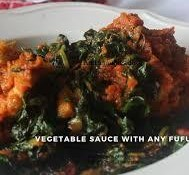

In [54]:
import random
from PIL import Image

#Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

#Pick a random image path
random_image_path = random.choice(image_path_list)

#Get image class from path name
image_class = random_image_path.parent.stem

#Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

In [55]:
import random
from PIL import Image
import os

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

try:
    # Pick a random image path
    random_image_path = random.choice(image_path_list)

    # Get image class from path name
    image_class = random_image_path.parent.stem

    # Open Image
    img = Image.open(random_image_path)

    # Print metadata
    print(f"Random Image Path: {random_image_path}")
    print(f"Image Class: {image_class}")
    print(f"Image Height: {img.height}")
    print(f"Image Width: {img.width}")

except IndexError:
    print("No image files found in the specified directory.")
except Exception as e:
    print(f"An error occurred: {e}")

Random Image Path: /content/data/images/train/eforiro/25.jpg
Image Class: eforiro
Image Height: 168
Image Width: 300


### Visualizing an Image using the matplotlib library

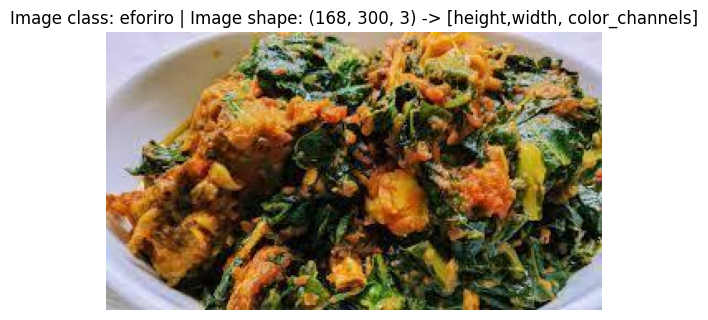

In [56]:
import numpy as np
import matplotlib.pyplot as plt

#Turn the image into an array
img_as_array = np.asarray(img)

#Plot the image with matplotlib
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height,width, color_channels]")
plt.axis(False);

## Transforming Data

In [57]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with torchvision.transforms

Transforms help you get your images ready to be used with a model/perform data augmentation

In [58]:
# Write a transform for image
data_transform = transforms.Compose([
    #Resize our images to 64x64
    transforms.Resize(size=(256, 256)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into a Torch.Tensor
    transforms.ToTensor()
])

In [59]:
data_transform(img).shape

torch.Size([3, 256, 256])

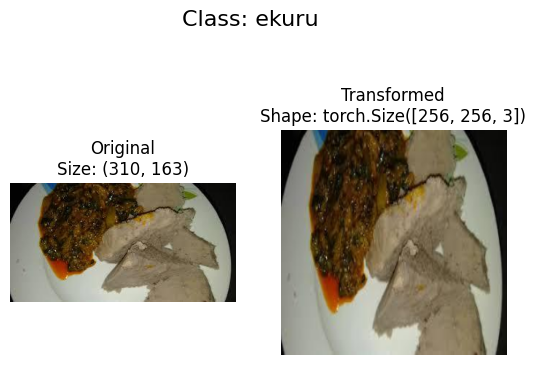

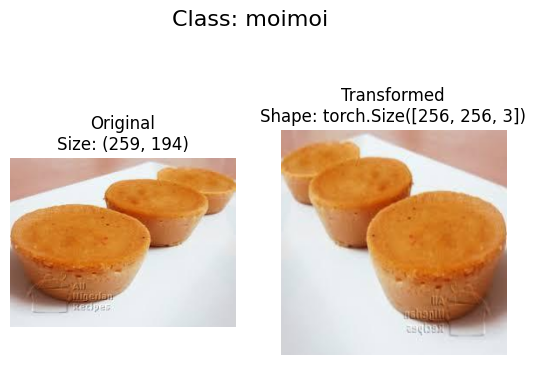

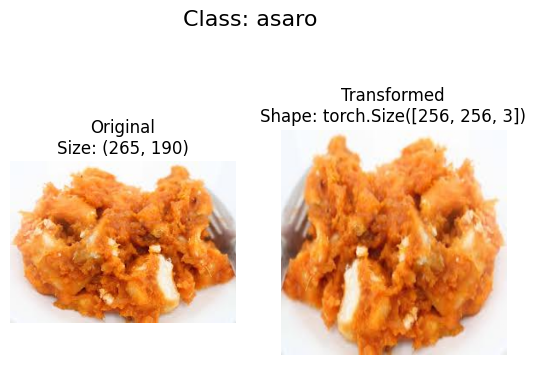

In [60]:
def plot_transformed_images(image_paths, transforms, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transform
  them, then plots the original vs the transformed version
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

    # Transform and plot target image
    transformed_image = transforms(f).permute((1, 2, 0))  #note we will need to change shape for matplotlib
    ax[1].imshow(transformed_image)
    ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
    ax[1].axis("off")

    fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transforms=data_transform,
                        n=3,
                        seed=None)

### Loading image data using `ImageFolder`

In [61]:
#Use Imagefolder to create dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,  #a transform for the data
                                  target_transform=None)  # a transform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 364
     Root location: /content/data/images/train
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 143
     Root location: /content/data/images/test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [62]:
# Get class names as list
class_names = train_data.classes
class_names

['asaro', 'eforiro', 'ekuru', 'ewagoyin', 'moimoi']

In [63]:
#Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'asaro': 0, 'eforiro': 1, 'ekuru': 2, 'ewagoyin': 3, 'moimoi': 4}

In [64]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(364, 143)

In [65]:
train_data.samples[0]

('/content/data/images/train/asaro/0.jpg', 0)

In [66]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.4196, 0.4196, 0.4196,  ..., 0.1686, 0.1843, 0.1882],
         [0.4196, 0.4196, 0.4196,  ..., 0.1686, 0.1843, 0.1882],
         [0.4157, 0.4157, 0.4157,  ..., 0.1686, 0.1843, 0.1882],
         ...,
         [0.2824, 0.2824, 0.2824,  ..., 0.1843, 0.1373, 0.1333],
         [0.2824, 0.2824, 0.2824,  ..., 0.1216, 0.0706, 0.0667],
         [0.2824, 0.2824, 0.2824,  ..., 0.1216, 0.0706, 0.0667]],

        [[0.3922, 0.3922, 0.3922,  ..., 0.1333, 0.1529, 0.1569],
         [0.3922, 0.3922, 0.3922,  ..., 0.1333, 0.1529, 0.1569],
         [0.3922, 0.3922, 0.3882,  ..., 0.1333, 0.1490, 0.1529],
         ...,
         [0.2667, 0.2667, 0.2667,  ..., 0.1137, 0.0667, 0.0627],
         [0.2667, 0.2667, 0.2667,  ..., 0.0510, 0.0039, 0.0000],
         [0.2667, 0.2667, 0.2667,  ..., 0.0510, 0.0039, 0.0000]],

        [[0.4196, 0.4196, 0.4157,  ..., 0.0588, 0.0784, 0.0824],
         [0.4196, 0.4196, 0.4157,  ..., 0.0588, 0.0784, 0.0824],
         [0.4157, 0.4157, 0.4078,  ..., 0.0

Original shape: torch.Size([3, 256, 256]) -> [color_channels, height, width]
Image permute: torch.Size([256, 256, 3]) -> [height, width, color_channels]


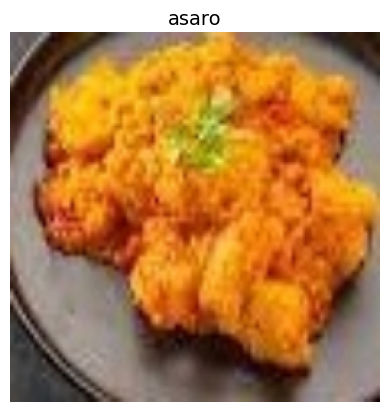

In [67]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

#Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [68]:
# Turn train and test datasets into Dataloaders
from torch.utils.data import DataLoader
Batch_size = 8
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=Batch_size,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=Batch_size,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79d765adf130>,
 <torch.utils.data.dataloader.DataLoader at 0x79d765adf190>)

In [69]:
len(train_dataloader), len(test_dataloader)

(46, 18)

In [70]:
img, label = next(iter(train_dataloader))

#Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([8, 3, 256, 256]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


## Creating a model class

In [71]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Expaliner
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,
                     stride=2) #default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,
                     stride=2) #default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*66*66,
                  out_features=output_shape)
    )


  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [72]:
model = TinyVGG(input_shape=3,
                hidden_units=20,
                output_shape = len(class_names)).to(device)
model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=87120, out_features=5, bias=True)
  )
)

In [73]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([8, 3, 256, 256]), torch.Size([8]))

In [74]:
#Try a forward pass
model(image_batch.to(device))

tensor([[ 0.0104,  0.0155,  0.0116, -0.0203,  0.0052],
        [ 0.0101,  0.0179,  0.0095, -0.0191,  0.0064],
        [ 0.0085,  0.0171,  0.0095, -0.0209,  0.0068],
        [ 0.0077,  0.0161,  0.0098, -0.0195,  0.0043],
        [ 0.0106,  0.0153,  0.0102, -0.0196,  0.0057],
        [ 0.0101,  0.0146,  0.0101, -0.0201,  0.0052],
        [ 0.0058,  0.0176,  0.0113, -0.0226,  0.0036],
        [ 0.0075,  0.0187,  0.0126, -0.0236,  0.0055]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [75]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 3, 256, 256])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 5]                    --
├─Sequential: 1-1                        [1, 20, 129, 129]         --
│    └─Conv2d: 2-1                       [1, 20, 258, 258]         560
│    └─ReLU: 2-2                         [1, 20, 258, 258]         --
│    └─Conv2d: 2-3                       [1, 20, 260, 260]         3,620
│    └─ReLU: 2-4                         [1, 20, 260, 260]         --
│    └─MaxPool2d: 2-5                    [1, 20, 129, 129]         --
├─Sequential: 1-2                        [1, 20, 66, 66]           --
│    └─Conv2d: 2-6                       [1, 20, 131, 131]         3,620
│    └─ReLU: 2-7                         [1, 20, 131, 131]         --
│    └─Conv2d: 2-8                       [1, 20, 133, 133]         3,620
│    └─ReLU: 2-9                         [1, 20, 133, 133]         --
│    └─MaxPool2d: 2-10                   [1, 20, 66, 66]           --
├─Seq

In [76]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  #Put the model in train mode
  model.train()

  # Set up train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    #Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1.Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [77]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # set up loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    #Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      #Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calulate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics ro get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [78]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

  # 2. Create empty results dictionary
  results ={"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

In [81]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 100

# Recreate an instance of TinyVGG
model= TinyVGG(input_shape=3,
                  hidden_units=20,
                   output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.00001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

#Train model_0
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.5678 | Train acc: 0.3370 | Test loss: 1.5229 | Test acc: 0.3472
Epoch: 1 | Train loss: 1.5099 | Train acc: 0.3478 | Test loss: 1.5016 | Test acc: 0.3472
Epoch: 2 | Train loss: 1.4995 | Train acc: 0.3478 | Test loss: 1.4950 | Test acc: 0.3472
Epoch: 3 | Train loss: 1.4937 | Train acc: 0.3424 | Test loss: 1.4876 | Test acc: 0.3472
Epoch: 4 | Train loss: 1.4844 | Train acc: 0.3478 | Test loss: 1.4775 | Test acc: 0.3472
Epoch: 5 | Train loss: 1.4758 | Train acc: 0.3451 | Test loss: 1.4634 | Test acc: 0.3472
Epoch: 6 | Train loss: 1.4596 | Train acc: 0.3451 | Test loss: 1.4458 | Test acc: 0.3472
Epoch: 7 | Train loss: 1.4400 | Train acc: 0.3424 | Test loss: 1.4175 | Test acc: 0.3472
Epoch: 8 | Train loss: 1.3987 | Train acc: 0.3614 | Test loss: 1.3815 | Test acc: 0.3780
Epoch: 9 | Train loss: 1.3681 | Train acc: 0.4402 | Test loss: 1.3407 | Test acc: 0.4841
Epoch: 10 | Train loss: 1.3223 | Train acc: 0.4973 | Test loss: 1.3000 | Test acc: 0.5119
Epoch: 11 | Train lo

In [82]:
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  #Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(10, 7))

  #Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

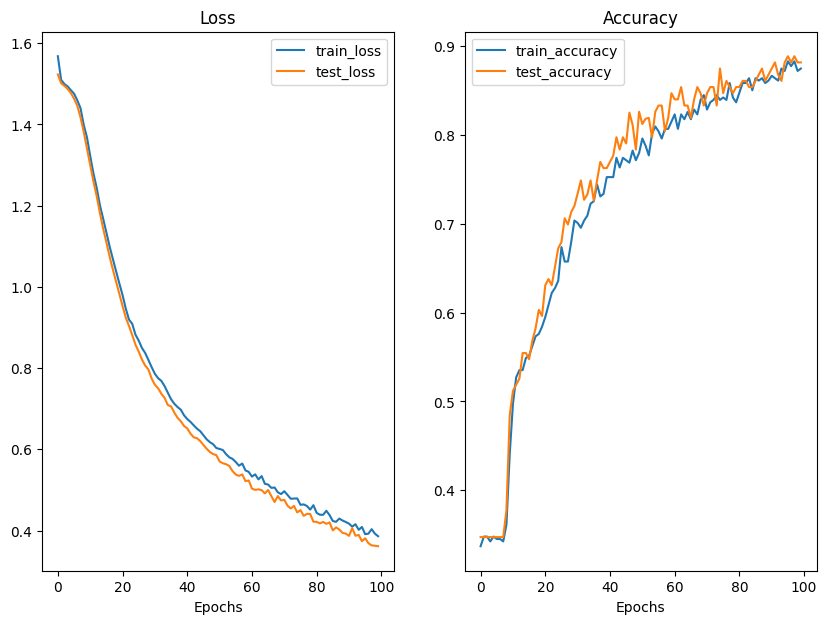

In [83]:
plot_loss_curves(model_results)

### Making prediction on a custom image

In [84]:
import requests
from pathlib import Path
import unrar

#Setup path to a data folder

custom_image_path = data_path / "custom_images"

# Download the image if it doesn't already exists
if custom_image_path.is_dir():
  print(f"{custom_image_path} directory already exists... skipping download")
else:
  print(f"{custom_image_path} directory does not exists... creating now")
  custom_image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "custom_images.rar", "wb") as f:
  request = requests.get("https://github.com/Adebesin-Aramide/Foodie_lens/raw/main/custom_images.rar")
  print("downloading the custom images...")
  f.write(request.content)

data/custom_images directory does not exists... creating now
downloading the custom images...


In [85]:
!unrar x -inul /content/data/custom_images.rar -d /content/data/

In [86]:
import os

# Specify the path to the folder containing the extracted images
custom_image_folder_path = Path("/content/data/custom_images")

# List all files in the folder
image_files = os.listdir(custom_image_folder_path)

# Create a list to store the full paths of the images
image_paths = []

# Iterate through the image files and create the full paths
for file_name in image_files:
    # Check if the file is an image file (you can add more checks if necessary)
    if file_name.endswith('.jpg') or file_name.endswith('.jpeg') or file_name.endswith('.png'):
        # Construct the full path to the image file
        image_path = os.path.join(custom_image_folder_path, file_name)
        # Append the image path to the list
        image_paths.append(image_path)

# Print the list of image paths
print(image_paths)


['/content/data/custom_images/images204.jpg', '/content/data/custom_images/images130.jpg', '/content/data/custom_images/images88.jpg', '/content/data/custom_images/images18.jpg', '/content/data/custom_images/ewa-agoyin-1-8.jpg', '/content/data/custom_images/images45.jpg', '/content/data/custom_images/yam-porridge-asaro.jpg', '/content/data/custom_images/porridge.jpg', '/content/data/custom_images/how-to-make-yam-porridge-03-1.jpg', '/content/data/custom_images/image19.jpeg', '/content/data/custom_images/hqdefault2.jpg', '/content/data/custom_images/images79.jpg', '/content/data/custom_images/Buy-MoinMoin-Elewe-300x300.jpg', '/content/data/custom_images/moi-moi-2-500x375.jpg', '/content/data/custom_images/images29.jpg', '/content/data/custom_images/moimoi-3.jpg', '/content/data/custom_images/ewa_agoyin_6055.jpg']


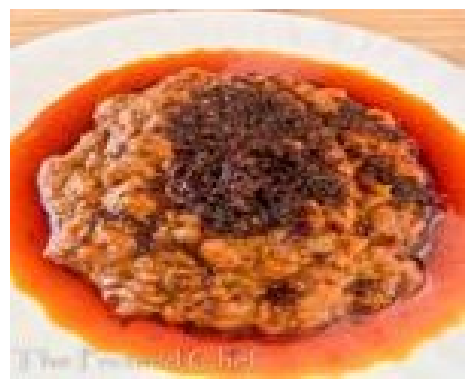

In [87]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
# Choose a random image file from the list
random_image_file = random.choice(image_files)

# Construct the full path to the random image file
random_image_path = os.path.join(custom_image_folder_path, random_image_file)

# Load the random image using matplotlib
random_image = mpimg.imread(random_image_path)

# Display the random image using matplotlib
plt.imshow(random_image)
plt.axis('off')  # Hide axis
plt.show()

In [88]:
random_image.shape

(122, 150, 3)

In [89]:
import torchvision.io as io
# Define a list to store tensor representations of images
tensor_images = []

# Iterate through each image file
for image_path in image_paths:
    # Read the image and convert it to a PyTorch tensor
    image_tensor = io.read_image(image_path)

    # Convert image tensor to torch.float32 and normalize
    image_tensor = image_tensor.float() / 255

    # Append the tensor representation to the list
    tensor_images.append(image_tensor)


In [90]:
# import torchvision
# # load in the custom image and convert to torch.float32
# custom_image = torchvision.io.read_image(str(image_paths)).type(torch.float32) / 255
# custom_image

In [91]:
# Create transform pipeline to resize image
from torchvision import transforms

# Define the transform
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(256, 256))
])

# Create a list to store transformed images
custom_image_transformed = []

# Apply the transformation to each image in the list
for image_tensor in tensor_images:
    transformed_image = custom_image_transform(image_tensor)
    custom_image_transformed.append(transformed_image)

# Print out the shape of the transformed images
print(f"Original shape: {tensor_images[0].shape}")
print(f"Transformed shape: {custom_image_transformed[0].shape}")


Original shape: torch.Size([3, 150, 150])
Transformed shape: torch.Size([3, 256, 256])


In [92]:
import torch
import torchvision
import matplotlib.pyplot as plt
from typing import List

def pred_and_plot_images(model: torch.nn.Module,
                         image_paths: List[str],
                         class_names: List[str] = None,
                         transform=None,
                         device=None):
    """Make predictions on target images with a trained model and plot the images and predictions"""
    if device is None:
        device = torch.device('cpu')

    # Make sure the model is on the target device
    model.to(device)

    for idx, image_path in enumerate(image_paths):
        # Load in the image
        target_image = torchvision.io.read_image(image_path).type(torch.float32)

        # Divide the image pixel values by 255 to get them between [0, 1]
        target_image = target_image / 255

        # Transform if necessary
        if transform:
            target_image = transform(target_image)

        # Turn on eval/inference mode and make a prediction
        with torch.inference_mode():
            # Add an extra dimension to the image (this is the batch dimension e.g., our model will predict on batches of 1x image)
            target_image = target_image.unsqueeze(0)

            # Make a prediction on the image with an extra dimension
            target_image_pred = model(target_image.to(device))  # make sure the target image is on the right device

        # Convert logits -> prediction probabilities
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        # Convert prediction probabilities -> prediction labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1).item()

        # Get the predicted class name if available
        if class_names:
            predicted_class_name = class_names[target_image_pred_label]
        else:
            predicted_class_name = "Unknown"

        # Create a title for the plot
        title_text = f"Pred: {predicted_class_name} | Prob: {target_image_pred_probs.max().item():.3f}"

        # Plot the image alongside the prediction and prediction probability
        plt.figure()
        plt.imshow(target_image.squeeze().permute(1, 2, 0))  # remove batch dimension and rearrange shape to be HWC
        plt.title(title_text)
        plt.axis('off')


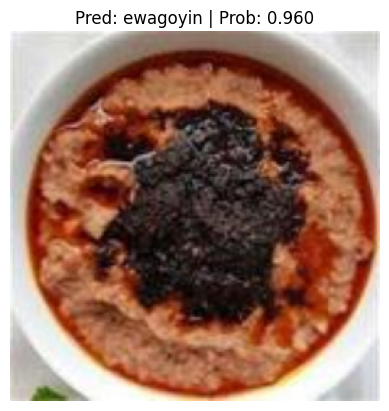

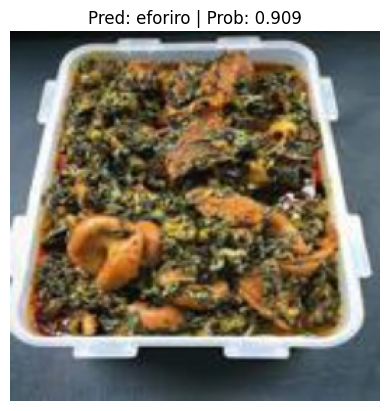

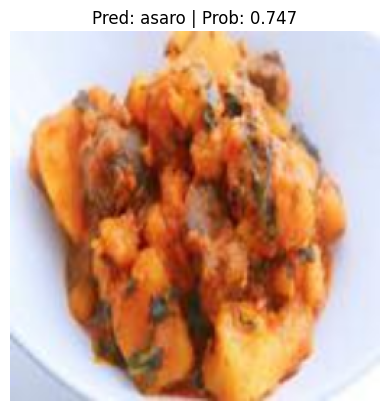

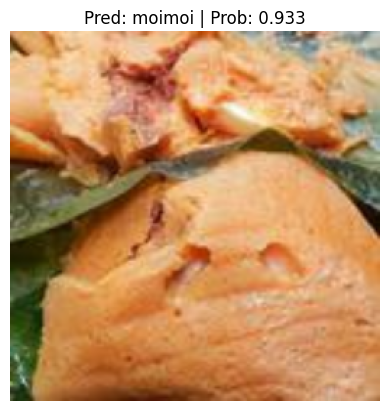

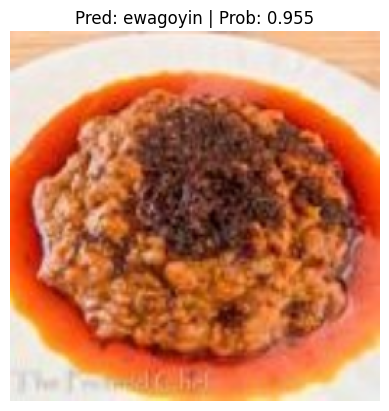

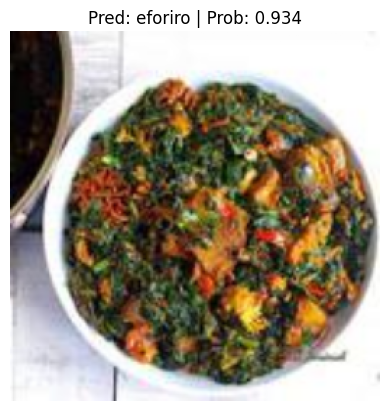

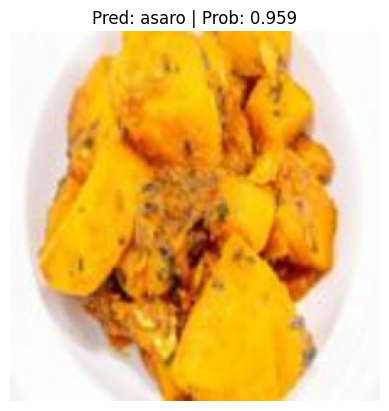

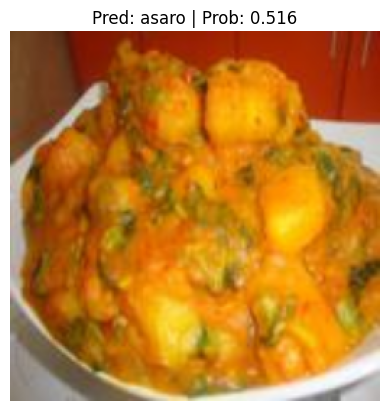

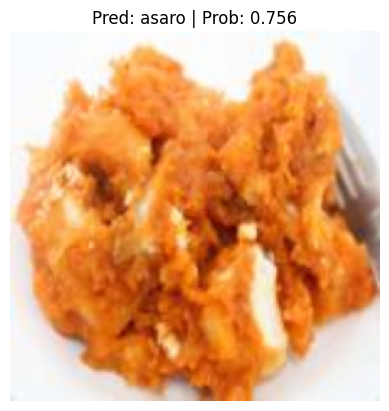

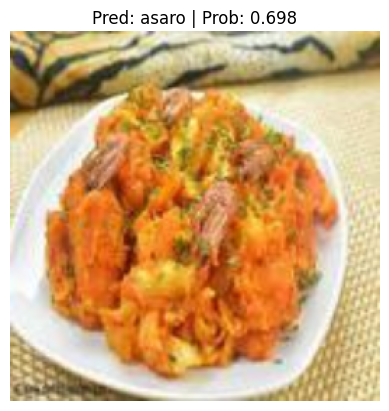

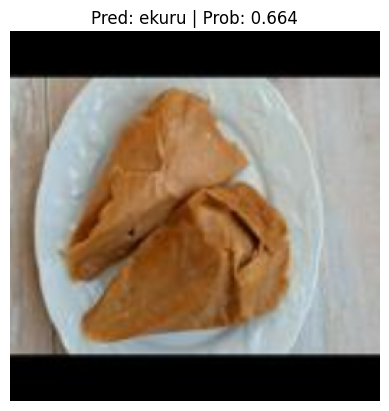

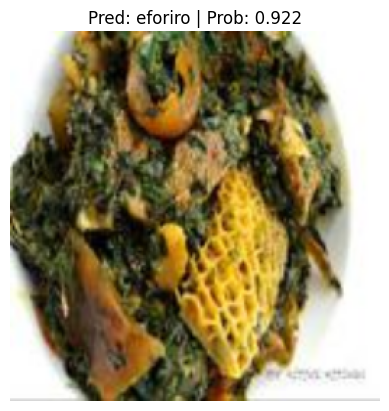

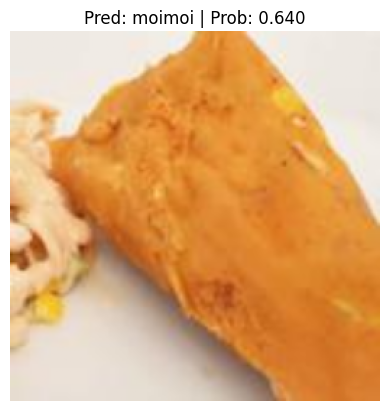

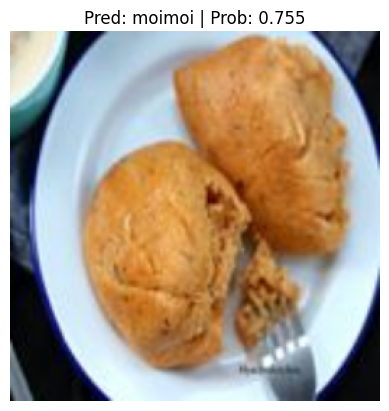

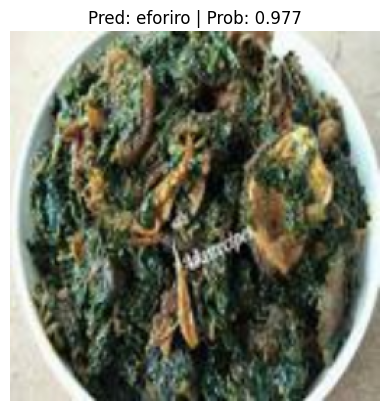

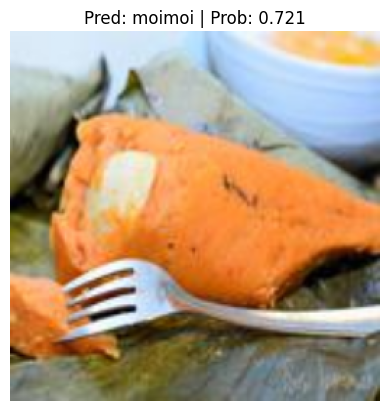

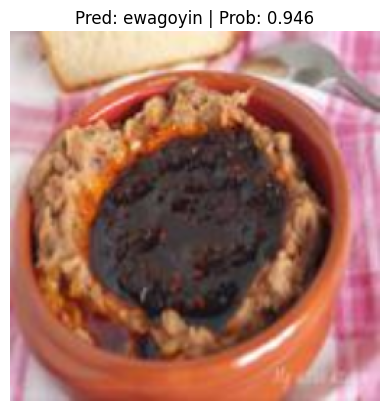

In [93]:
# Pred on our custom image
pred_and_plot_images(model=model,
                    image_paths=image_paths,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

### Saving the Model

In [94]:
from pathlib import Path

#Create model directory path
Model_path = Path("models")
Model_path.mkdir(parents=True,
                 exist_ok=True)

#Create model save
model_name = "foodie_lens_model2.pth"
model_save_path = Model_path / model_name

#Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(),
           f=model_save_path)

Saving model to: models/foodie_lens_model2.pth
